## TF Lite - Android App Intent Hijacking Classifier

This notebook preprocesses a dataset of Android app features, trains a Random Forest Classifier to detect malicious apps vulnerable to implicit intent hijacking, and converts the model to TensorFlow Lite (TFLite) for deployment on an Android AVD 

## Dataset
- Features: 51 parameters (Intent actions, broadcast APIs, permissions, service bindings).
- Labels: B (Benign) = 0, S (Malware) = 1.
- Input file: `dataset.csv`.

## Steps
1. Import libraries
2. Preprocess the dataset.
3. Train a Random Forest Classifier.
4. Convert to TFLite.
5. Save the model for Android deployment.

## Importing Required Libraries

In [27]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import pickle
import os

## Load and Preview the Dataset

In this step, we load the dataset from a CSV file named dataset.csv using pandas, which is a powerful library for data manipulation and analysis in Python. The read_csv() function reads the CSV file and stores it in a DataFrame named data.

In [28]:
# Load dataset
data = pd.read_csv('dataset.csv')

# Display first few rows
data.head()

C:\Users\Shahzaib\AppData\Local\Temp\ipykernel_27564\2645059043.py:2: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')  # Update with your dataset path


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S


In [29]:
data.shape

(15036, 216)

In [30]:
print(data.dtypes)

transact                       int64
onServiceConnected             int64
bindService                    int64
attachInterface                int64
ServiceConnection              int64
                               ...  
ACCESS_FINE_LOCATION           int64
SET_WALLPAPER_HINTS            int64
SET_PREFERRED_APPLICATIONS     int64
WRITE_SECURE_SETTINGS          int64
class                         object
Length: 216, dtype: object


In [31]:
print(data.dtypes[92])

object


C:\Users\Shahzaib\AppData\Local\Temp\ipykernel_27564\2545174819.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data.dtypes[92])


## Feature Selection and Dataset Preprocessing

In this step, we perform manual feature selection by defining a list of 51 relevant features related to intent actions, permissions, API calls, and system services that are commonly involved in implicit intent hijacking.

In [32]:
# Define the 51 selected features 
features = [
    'android.intent.action.SEND', 'android.intent.action.SEND_MULTIPLE', 'android.intent.action.BOOT_COMPLETED',
    'android.intent.action.PACKAGE_REPLACED', 'android.intent.action.PACKAGE_REMOVED', 'android.intent.action.PACKAGE_ADDED',
    'android.intent.action.PACKAGE_DATA_CLEARED', 'android.intent.action.TIME_SET', 'android.intent.action.TIMEZONE_CHANGED',
    'android.intent.action.ACTION_POWER_DISCONNECTED', 'android.intent.action.ACTION_POWER_CONNECTED', 'android.intent.action.SENDTO',
    'android.intent.action.NEW_OUTGOING_CALL', 'android.intent.action.CALL', 'android.intent.action.ACTION_SHUTDOWN',
    'android.intent.action.BATTERY_LOW', 'android.intent.action.BATTERY_OKAY', 'android.intent.action.PACKAGE_RESTARTED',
    'android.intent.action.CALL_BUTTON', 'android.intent.action.SCREEN_ON', 'android.intent.action.SCREEN_OFF',
    'Landroid.content.Context.registerReceiver', 'abortBroadcast', 'BROADCAST_SMS', 'BROADCAST_WAP_PUSH', 'BROADCAST_STICKY',
    'bindService', 'onServiceConnected', 'ServiceConnection', 'BIND_REMOTEVIEWS', 'BIND_VPN_SERVICE',
    'BIND_WALLPAPER', 'BIND_ACCESSIBILITY_SERVICE', 'BIND_APPWIDGET', 'BIND_TEXT_SERVICE',
    'SEND_SMS', 'RECEIVE_SMS', 'READ_SMS', 'WRITE_SMS', 'RECEIVE_MMS', 'RECEIVE_WAP_PUSH',
    'CALL_PHONE', 'PROCESS_OUTGOING_CALLS', 'CALL_PRIVILEGED', 'RECEIVE_BOOT_COMPLETED',
    'READ_CONTACTS', 'WRITE_CONTACTS', 'ACCESS_FINE_LOCATION', 'ACCESS_COARSE_LOCATION', 'INTERNET', 'android.os.Binder'
]

# Load dataset
data = pd.read_csv('dataset.csv')  

# Validate features
missing_features = [f for f in features if f not in data.columns]
if missing_features:
    print('Error: The following features are missing in the dataset:', missing_features)
    print('Dataset columns:', data.columns.tolist())
    raise KeyError('Fix the features list to match dataset columns')

# Ensure class column exists
if 'class' not in data.columns:
    print('Error: class column not found in dataset')
    print('Dataset columns:', data.columns.tolist())
    raise KeyError('Add class column to dataset')

# Select 51 features and class column
data = data[features + ['class']]

# Convert labels: B (benign) = 0, S (malware) = 1
data['class'] = data['class'].apply(lambda x: 1 if x == 'S' else 0)

# Save preprocessed dataset
data.to_csv('preprocessed_dataset.csv', index=False)
print('Preprocessed dataset saved as preprocessed_dataset.csv')

# Display first few rows
data.head()

C:\Users\Shahzaib\AppData\Local\Temp\ipykernel_27564\278750269.py:19: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')  # Update with your dataset path


Preprocessed dataset saved as preprocessed_dataset.csv


,android.intent.action.SEND,android.intent.action.SEND_MULTIPLE,android.intent.action.BOOT_COMPLETED,android.intent.action.PACKAGE_REPLACED,android.intent.action.PACKAGE_REMOVED,android.intent.action.PACKAGE_ADDED,android.intent.action.PACKAGE_DATA_CLEARED,android.intent.action.TIME_SET,android.intent.action.TIMEZONE_CHANGED,android.intent.action.ACTION_POWER_DISCONNECTED,...,PROCESS_OUTGOING_CALLS,CALL_PRIVILEGED,RECEIVE_BOOT_COMPLETED,READ_CONTACTS,WRITE_CONTACTS,ACCESS_FINE_LOCATION,ACCESS_COARSE_LOCATION,INTERNET,android.os.Binder,class
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,1


## Exploratory Data Analysis (EDA)

This step involves analyzing the preprocessed dataset to gain insights into the distribution, structure, and behavior of the features. It also helps identify potential issues such as constant or highly correlated features that may impact model performance.

Dataset Shape: (15036, 52)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 52 columns):
 #   Column                                           Non-Null Count  Dtype
---  ------                                           --------------  -----
 0   android.intent.action.SEND                       15036 non-null  int64
 1   android.intent.action.SEND_MULTIPLE              15036 non-null  int64
 2   android.intent.action.BOOT_COMPLETED             15036 non-null  int64
 3   android.intent.action.PACKAGE_REPLACED           15036 non-null  int64
 4   android.intent.action.PACKAGE_REMOVED            15036 non-null  int64
 5   android.intent.action.PACKAGE_ADDED              15036 non-null  int64
 6   android.intent.action.PACKAGE_DATA_CLEARED       15036 non-null  int64
 7   android.intent.action.TIME_SET                   15036 non-null  int64
 8   android.intent.action.TIMEZONE_CHANGED           15036 non-null  int64
 9   android.

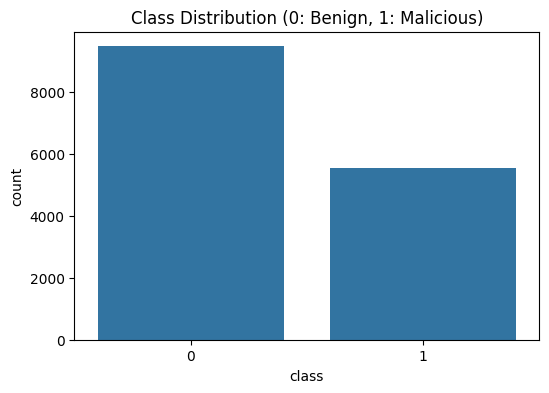


Feature Usage (% of apps with feature = 1):
INTERNET                                           87.197393
Landroid.content.Context.registerReceiver          50.345837
android.os.Binder                                  48.689811
android.intent.action.BOOT_COMPLETED               44.912211
onServiceConnected                                 44.659484
ServiceConnection                                  44.493216
bindService                                        44.267092
RECEIVE_BOOT_COMPLETED                             38.434424
ACCESS_FINE_LOCATION                               29.083533
ACCESS_COARSE_LOCATION                             28.272147
SEND_SMS                                           23.663208
READ_CONTACTS                                      23.330673
RECEIVE_SMS                                        18.715084
READ_SMS                                           18.675180
CALL_PHONE                                         11.432562
WRITE_SMS                               

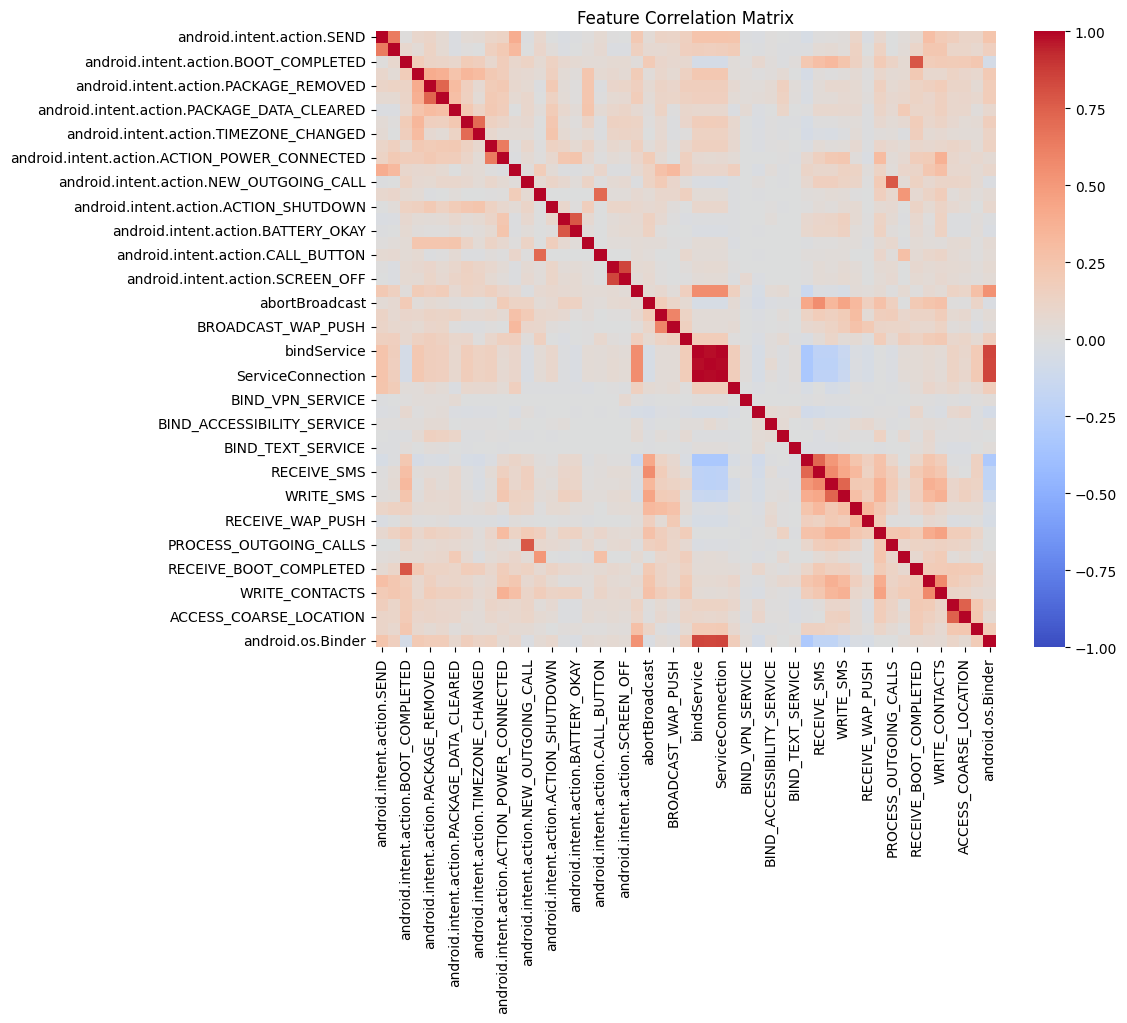


Highly Correlated Feature Pairs (|corr| > 0.8):
android.intent.action.SCREEN_ON and android.intent.action.SCREEN_OFF: 0.85
bindService and onServiceConnected: 0.98
bindService and ServiceConnection: 0.99
bindService and android.os.Binder: 0.85
onServiceConnected and ServiceConnection: 0.98
onServiceConnected and android.os.Binder: 0.84
ServiceConnection and android.os.Binder: 0.85

Invalid Values in Features (non 0/1):
Series([], dtype: int64)


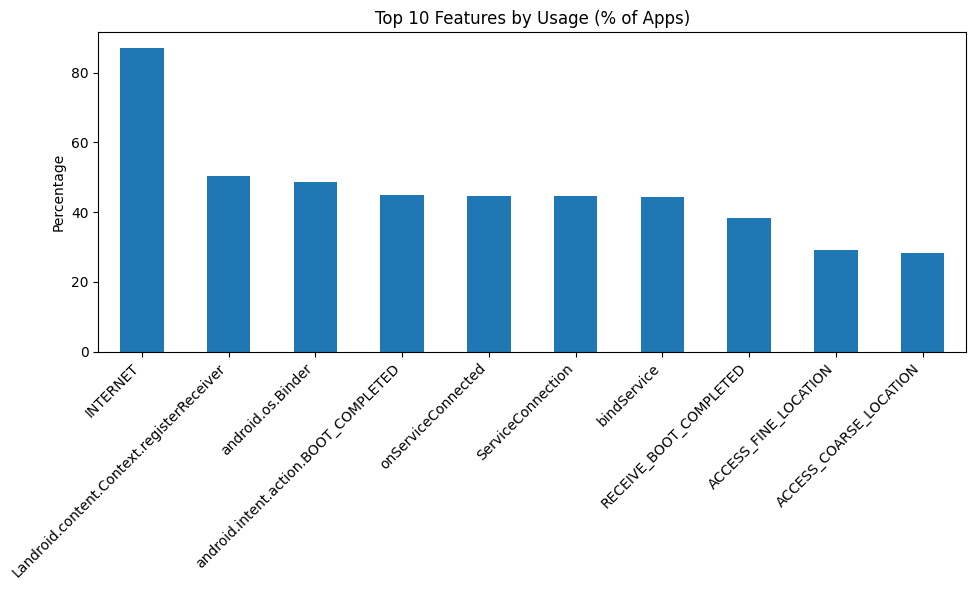

In [33]:
# Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataset Shape and Info
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
data.info()
print("\nMissing Values:")
print(data.isnull().sum())

# 2. Class Distribution
print("\nClass Distribution:")
print(data['class'].value_counts(normalize=True) * 100)  # Percentage of benign (0) vs malicious (1)
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=data)
plt.title('Class Distribution (0: Benign, 1: Malicious)')
plt.show()

# 3. Feature Analysis
# Feature usage (proportion of 1s for each binary feature)
feature_usage = data[features].mean() * 100  # Percentage of apps with each feature
print("\nFeature Usage (% of apps with feature = 1):")
print(feature_usage.sort_values(ascending=False))

# Identify constant features
constant_features = [col for col in features if data[col].nunique() == 1]
print("\nConstant Features (no variation):", constant_features)

# Correlation matrix (for binary features)
plt.figure(figsize=(10, 8))
correlation_matrix = data[features].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Highlight highly correlated feature pairs (|correlation| > 0.8)
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
                   for i, j in zip(*high_corr) if i != j and i < j]
print("\nHighly Correlated Feature Pairs (|corr| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

# 4. Outlier Detection (for binary features, check for invalid values)
invalid_values = data[features].apply(lambda x: ~x.isin([0, 1]).sum())
print("\nInvalid Values in Features (non 0/1):")
print(invalid_values[invalid_values > 0])

# 5. Top Features by Usage
top_features = feature_usage.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title('Top 10 Features by Usage (% of Apps)')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Feature Selection and Model Training

Following the insights from EDA, we performed feature selection and trained two classifiers to detect malicious apps.


In [34]:
# Feature Selection based on EDA
# Drop low-usage features (<1%)
feature_usage = data[features].mean() * 100
low_usage_features = feature_usage[feature_usage < 1].index.tolist()
print("Dropping low-usage features:", low_usage_features)

# Drop highly correlated features
features_to_drop = ['onServiceConnected', 'ServiceConnection', 'android.os.Binder', 'android.intent.action.SCREEN_OFF']
print("Dropping correlated features:", features_to_drop)

# Combine features to drop
features_to_drop = list(set(low_usage_features + features_to_drop))
features = [f for f in features if f not in features_to_drop]
data = data[features + ['class']]
print(f"Remaining features: {len(features)}")

# Prepare features and labels (your original code)
X = data.drop('class', axis=1).values
y = data['class'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# apply SMOTE for class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE, training set class distribution:", pd.Series(y_train).value_counts())

# Training Random Forest with class weights
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

import xgboost as xgb

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,      # Maximum depth of trees
    learning_rate=0.1, # Step size shrinkage
    random_state=42,
    use_label_encoder=False,  
    eval_metric='logloss'     
)

# Training the XGBoost model
xgb_model.fit(X_train, y_train)
print("XGBoost model trained successfully!")

# Evaluate Both Models (expanded)
# Random Forest Evaluation
y_pred_rf = rf.predict(X_test)
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Random Forest Classification Report:\n', classification_report(y_test, y_pred_rf))

# XGBoost Evaluation
y_pred_xgb = xgb_model.predict(X_test)
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('XGBoost Classification Report:\n', classification_report(y_test, y_pred_xgb))

Dropping low-usage features: ['android.intent.action.CALL', 'android.intent.action.BATTERY_LOW', 'android.intent.action.BATTERY_OKAY', 'android.intent.action.PACKAGE_RESTARTED', 'android.intent.action.CALL_BUTTON', 'android.intent.action.SCREEN_ON', 'android.intent.action.SCREEN_OFF', 'BROADCAST_SMS', 'BROADCAST_WAP_PUSH', 'BIND_VPN_SERVICE', 'BIND_ACCESSIBILITY_SERVICE', 'BIND_APPWIDGET', 'BIND_TEXT_SERVICE', 'CALL_PRIVILEGED']
Dropping correlated features: ['onServiceConnected', 'ServiceConnection', 'android.os.Binder', 'android.intent.action.SCREEN_OFF']
Remaining features: 34
After SMOTE, training set class distribution: 0    7613
1    7613
Name: count, dtype: int64


C:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:55:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained successfully!
Random Forest Accuracy: 0.9132313829787234
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1863
           1       0.85      0.94      0.89      1145

    accuracy                           0.91      3008
   macro avg       0.90      0.92      0.91      3008
weighted avg       0.92      0.91      0.91      3008

XGBoost Accuracy: 0.9072473404255319
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      1863
           1       0.84      0.93      0.88      1145

    accuracy                           0.91      3008
   macro avg       0.90      0.91      0.90      3008
weighted avg       0.91      0.91      0.91      3008



## ROC-AUC Score Evaluation

To assess how well our classifiers distinguish between benign and malicious apps, we used the ROC-AUC (Receiver Operating Characteristic - Area Under Curve) metric.

In [36]:
# Import required metrics
from sklearn.metrics import roc_auc_score, roc_curve

# Compute ROC-AUC scores
rf_prob = rf.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_prob)
xgb_roc_auc = roc_auc_score(y_test, xgb_prob)
print("Random Forest ROC-AUC:", rf_roc_auc)
print("XGBoost ROC-AUC:", xgb_roc_auc)

Random Forest ROC-AUC: 0.9789399170704152
XGBoost ROC-AUC: 0.976470312474363


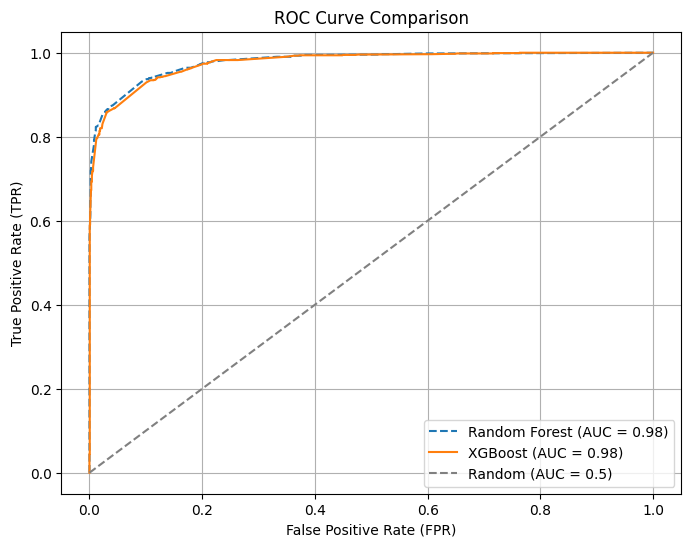

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Compute ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_roc_auc:.2f})", linestyle='--')
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_roc_auc:.2f})", linestyle='-')

# Reference line for random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed', label="Random (AUC = 0.5)")

# Labels and Title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()

# Show the plot
plt.show()


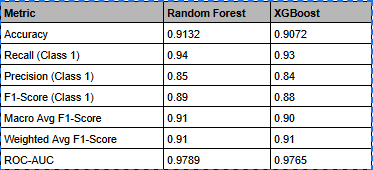

## Top 10 Important Features (Random Forest)

We used the feature_importances_ attribute from the trained Random Forest classifier to identify which features are most influential in detecting malicious apps.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance values
feature_importance = rf.feature_importances_

# Create a DataFrame to sort features by importance
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(features_df.head(10))


Top 10 Most Important Features:
                                      Feature  Importance
17                                bindService    0.223698
20                                   SEND_SMS    0.169941
14  Landroid.content.Context.registerReceiver    0.103024
33                                   INTERNET    0.073046
2        android.intent.action.BOOT_COMPLETED    0.056854
21                                RECEIVE_SMS    0.050687
22                                   READ_SMS    0.040214
0                  android.intent.action.SEND    0.036426
32                     ACCESS_COARSE_LOCATION    0.024848
28                     RECEIVE_BOOT_COMPLETED    0.019833


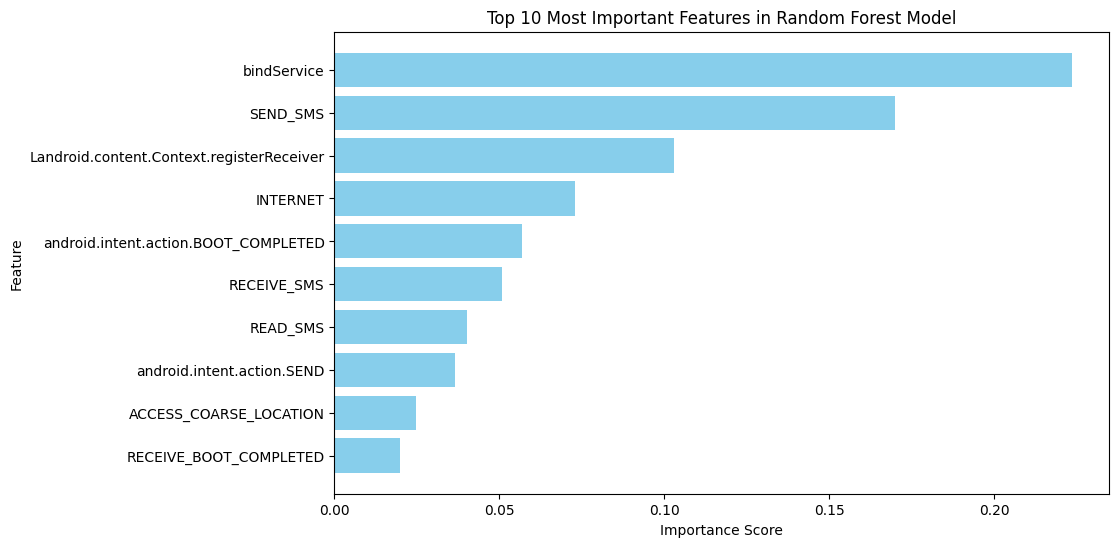

In [55]:
# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'][:10], features_df['Importance'][:10], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features in Random Forest Model")
plt.gca().invert_yaxis()  # Invert for better visualization
plt.show()


## Saving the Trained Random Forest Model

In [39]:
# Save Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
print('Random Forest model saved as rf_model.pkl')

Random Forest model saved as rf_model.pkl


## Distilling Random Forest to TensorFlow & Exporting to TFLite

This step is performing model distillation, where we're training a lightweight TensorFlow neural network to mimic the predictions of a complex model (Random Forest). Then, we converted that trained TF model into TensorFlow Lite (TFLite) format for deployment on mobile or edge devices.

Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8507 - loss: 0.3637 - val_accuracy: 0.9770 - val_loss: 0.0776
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9722 - loss: 0.0948 - val_accuracy: 0.9836 - val_loss: 0.0574
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9735 - loss: 0.0794 - val_accuracy: 0.9852 - val_loss: 0.0456
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9815 - loss: 0.0598 - val_accuracy: 0.9944 - val_loss: 0.0253
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9822 - loss: 0.0537 - val_accuracy: 0.9902 - val_loss: 0.0390
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9875 - loss: 0.0412 - val_accuracy: 0.9944 - val_loss: 0.0205
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9877 - loss: 0.0393 - val_accuracy: 0.9947 - val_loss: 0.0260
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9909 - loss: 0.0321 - val_accuracy: 0.

INFO:tensorflow:Assets written to: tf_model\assets


Saved artifact at 'tf_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 34), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2072599141392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2072599141968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2072599137360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2072599143696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2072599143120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2072599144464: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved as model.tflite


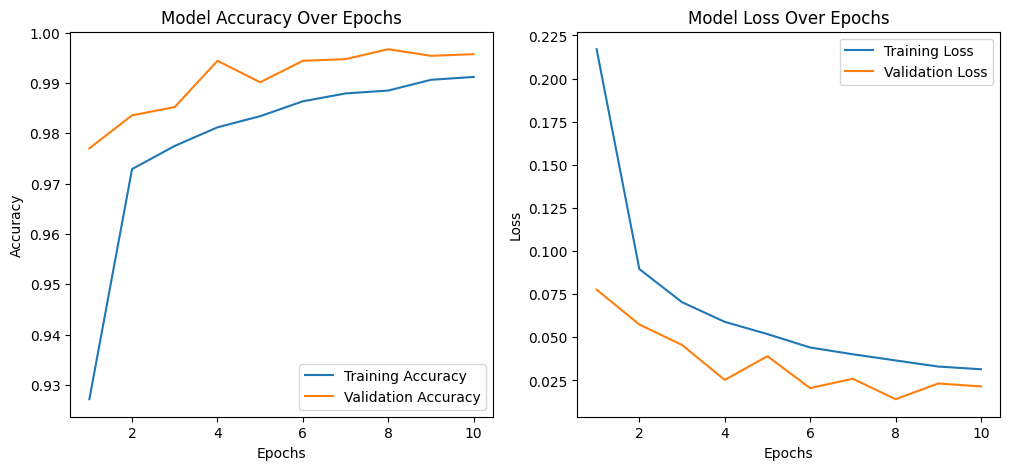

In [42]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt

# Creating a simple TF model
input_shape = X.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train TF model to mimic Random Forest predictions
y_rf_pred = rf.predict(X_train).reshape(-1, 1)
history = model.fit(X_train, y_rf_pred, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Save TF model in SavedModel format
model.export('tf_model')  

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('tf_model')
tflite_model = converter.convert()

# Save TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
print('TFLite model saved as model.tflite')


# Plot Accuracy & Loss
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.show()


## Evaluation of TF Lite model

In [44]:
# Test TFLite model
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [45]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [46]:
# Test with a sample from X_test
sample = X_test[0:1].astype(np.float32)  # First test sample
interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print('TFLite prediction:', 'Malware' if output[0][0] > 0.5 else 'Benign')
print('Random Forest prediction:', 'Malware' if rf.predict(X_test[0:1])[0] == 1 else 'Benign')
print('True label:', 'Malware' if y_test[0] == 1 else 'Benign')

TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign


In [47]:
# Run inference on X_test
y_tflite_pred = []
for i in range(len(X_test)):
    input_data = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_tflite_pred.append(1 if output_data[0][0] > 0.5 else 0)
y_tflite_pred = np.array(y_tflite_pred)
tflite_accuracy = accuracy_score(y_test, y_tflite_pred)
print('TFLite Model Accuracy:', tflite_accuracy)

TFLite Model Accuracy: 0.9119015957446809


In [60]:
# Test multiple samples
for i in range(10):  # Test first 5 samples
    sample = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    print(f'Sample {i+1}:')
    print('TFLite prediction:', 'Malware' if output[0][0] > 0.5 else 'Benign')
    print('Random Forest prediction:', 'Malware' if rf.predict(X_test[i:i+1])[0] == 1 else 'Benign')
    print('True label:', 'Malware' if y_test[i] == 1 else 'Benign')
    print()

Sample 1:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 2:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 3:
TFLite prediction: Malware
Random Forest prediction: Malware
True label: Benign

Sample 4:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Malware

Sample 5:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 6:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 7:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 8:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 9:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign

Sample 10:
TFLite prediction: Benign
Random Forest prediction: Benign
True label: Benign



Accuracy plot saved as accuracy_plot.png


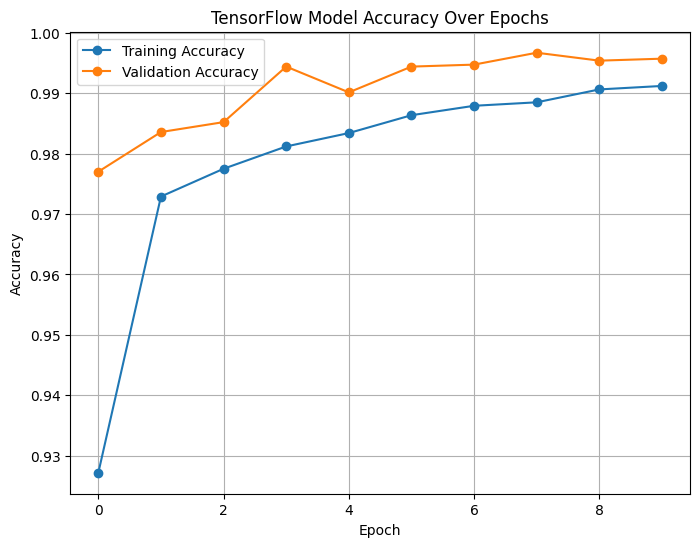

In [49]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('TensorFlow Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('accuracy_plot.png')
print('Accuracy plot saved as accuracy_plot.png')